In [1]:
!pip install tensorflow

In [6]:
!pip install pandas
!pip install scikit-learn


[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python3 -m pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 38.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.1/41.1 MB 35.1 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [295]:
from bs4 import BeautifulSoup
import requests
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Lambda, Layer, Input, Dense, Concatenate
from tensorflow.keras.layers import Flatten, Conv1D, Reshape, GlobalAveragePooling2D,LSTM, BatchNormalization, GlobalAveragePooling1D, GlobalMaxPooling1D, MultiHeadAttention
import json
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model

In [2]:
# Set TensorFlow to use only the CPU
tf.config.set_visible_devices([], 'GPU')

I0000 00:00:1722727014.894542  166958 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1722727014.963671  166958 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1722727014.963742  166958 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.


In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPUs detected:")
    for gpu in gpus:
        print(f"- {gpu}")
else:
    print("No GPUs detected.")

GPUs detected:
- PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [4]:
def get_csrf_token(session):
    """Fetches the CSRF token from the login page."""
    login_url = "https://www.heartharena.com/login"
    response = session.get(login_url)
    soup = BeautifulSoup(response.text, 'html.parser')
    csrf_token = soup.find("input", {"name": "_csrf_token"})["value"]
    return csrf_token
    
def login(username, password):
    """Logs in to the HearthArena website."""
    url = "https://www.heartharena.com/login_check"
    session = requests.Session()

    # Get CSRF token
    csrf_token = get_csrf_token(session)

    # Prepare payload
    payload = {
        "_username": username,
        "_password": password,
        "_csrf_token": csrf_token,
        "_remember_me": "on"  # Optional, based on whether you want to stay logged in
    }

    # Submit the login form
    response = session.post(url, data=payload)

    # Check if login was successful
    if response.status_code == 200:
        print("Login successful!")
    else:
        print("Login failed.")

    return session



In [5]:
def getRuns(arenaURL,session):
    # Initialize an empty list to store the links
    response = session.get(arenaURL)
    links = []
    end = BeautifulSoup(response.text, 'html')
    runs = end.find('tbody')
    # Find all 'a' tags within 'tr' elements and filter for those with 'href' attribute starting with '/arena-run/'
    for link in runs.find_all('tr'):
        anchor_tags = link.find_all('a')
        for tag in anchor_tags:
            href = tag.get('href')
            if href and href.startswith('/arena-run/'):
                links.append('https://www.heartharena.com'+href)
    links = list(set(links))
    return links

In [6]:
def getStatsFromRun(url):
    page = requests.get(url)
    soup = BeautifulSoup(page.text, 'html')
    nameExtract = soup.select('h1.class')[0].text.strip()
    parts = nameExtract.split('/')
       
    wins = 0
    deckList = 0
    champ = ""
    hasData = len(soup.find_all('span', class_='wins'))
    print(hasData)
    if hasData == 1:
        champ = parts[0].strip() 
        wins = int(soup.find_all('span', class_='wins')[0].text)
        arenaDeck = soup.find_all('ul', class_="deckList")[0]
        cardNames = arenaDeck.find_all('span', class_='name')
        cardAmount = arenaDeck.find_all('span', class_='quantity')
        # Extract and convert numeric values and names
        namesList = [(name.text.strip()) for name in cardNames]
        amountList = [int(amount.text.strip()) for amount in cardAmount]

        # Initialize an empty list to hold the repeated names
        deckList = []

        # Iterate through the names and amounts simultaneously
        for name, amount in zip(namesList, amountList):
            # Repeat the name 'amount' times and extend the repeated_names list
            deckList.extend([name] * amount)

    return champ, wins/12, deckList, hasData

In [7]:
import csv
import json

In [8]:

# Path to the JSON file
file_path = 'my_dict.json'

# Load JSON file and convert it to a dictionary
with open(file_path, 'r') as file:
    encodedDeck = json.load(file)


In [9]:

        
def encodeDeck(deck):
    stats_list = []
    desc_list = []
    for name in deck:
        if name in encodedDeck:
            data = encodedDeck[name]
            stats = data[0]
            desc = data[1]
            stats_list.append(stats)
            desc_list.append(desc)
    
    
    return [stats_list, desc_list]

In [10]:
classes = ['Death Knight','Demon Hunter','Druid','Hunter','Mage','Paladin','Preist','Rogue','Shaman','Warlock','Warrior']

# Initialize an empty dictionary to hold the encoding
encoded_classes = {}

# Iterate over each class name
for name in classes:
    # Check if the name is already in the dictionary
    if name not in encoded_classes:
        # If not, add it with a unique integer
        encoded_classes[name] = len(encoded_classes) + 1



def encodeClass(classData):
    empty_list1 = [0] * len(encoded_classes)
    empty_list2 = [0] * len(encoded_classes)
    separated_names = classData.split(' + ')
    empty_list1[encoded_classes.get(separated_names[0])-1]+=1
    empty_list2[encoded_classes.get(separated_names[1])-1]+=1
    return empty_list1+empty_list2
    

In [11]:
def scrapeArenaData(linksList):
    # Initialize an empty list to store the outputs
    outputs = []

        # Iterate through linksList
    for link in linksList:
        # Call getStatsFromRun for each link and append the result to outputs
        
        output = getStatsFromRun(link)    
        outputs.append(output)

    return outputs

In [12]:
def getTrainingData(arenaData):
    winRateList = []
    DeckList = []
    classList = []
    descList = []
    
    for run in arenaData:
        print(run[3])
        if run[3] == 1:
            classEncoded = encodeClass(run[0])
            
            winRate = run[1]
            deckEncoded = encodeDeck(run[2])
            
            classList.append(classEncoded)
            DeckList.append(deckEncoded[0])
            descList.append(deckEncoded[1])
            winRateList.append(winRate)
    
    
    return [classList,DeckList,descList], winRateList
    

In [128]:
session = login("mcbrideslade@gmail.com", "U$!*3YFvJS2@Dvd4")
arenaUrl = 'https://www.heartharena.com/my-arenas'
linksList = getRuns(arenaUrl,session)

Login successful!


In [129]:
arenaData = scrapeArenaData(linksList)

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


In [130]:
trainingdata, winratedata = getTrainingData(arenaData)

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


In [142]:
inputdata1 = trainingdata[0]
inputdata2 = trainingdata[1]
inputdata3 = trainingdata[2]

inputdatanp1 = np.array(inputdata1, dtype=np.float32)
inputdatanp2 = np.array(inputdata2, dtype=np.float32)
inputdatanp3 = np.array(inputdata3, dtype=np.float32)

winratedatanp = np.array(winratedata, dtype=np.float32)
print(inputdatanp1.shape)
print(inputdatanp2.shape)
print(inputdatanp3.shape)

(25, 22)
(25, 30, 5)
(25, 30, 30, 300)


In [143]:
# Define the custom DeepSetLayer with Dropout
class DeepSetLayer(layers.Layer):
    def __init__(self, output_dim, phi_units=[12, 12], rho_units=[12, 12], dropout_rate=0.2):
        super(DeepSetLayer, self).__init__()
        self.phi_layers = []
        for units in phi_units:
            self.phi_layers.append(layers.Dense(units, activation='gelu'))
            self.phi_layers.append(layers.Dropout(dropout_rate))
        
        self.rho_layers = []
        for units in rho_units:
            self.rho_layers.append(layers.Dense(units, activation='gelu'))
            self.rho_layers.append(layers.Dropout(dropout_rate))
        
        self.output_layer = layers.Dense(output_dim)
    
    def call(self, inputs, training=False):
        # Apply the transformation function Φ to each element
        x = inputs
        for layer in self.phi_layers:
            if isinstance(layer, layers.Dropout):
                x = layer(x, training=training)
            else:
                x = layer(x)
        
        # Aggregate the transformed elements (averaging)
        #x = tf.reduce_mean(x, axis=1)
        x = tf.reduce_max(x, axis=1)
        
        # Apply the aggregation function ρ
        for layer in self.rho_layers:
            if isinstance(layer, layers.Dropout):
                x = layer(x, training=training)
            else:
                x = layer(x)
        
        # Output layer
        output = self.output_layer(x)
        return output

In [331]:
class MaskingLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(MaskingLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        super(MaskingLayer, self).build(input_shape)

    def call(self, inputs):
        stats_input, words_input = inputs
        
        # Generate a binary mask
        batch_size = tf.shape(stats_input)[0]
        num_cards = tf.shape(stats_input)[1]
        
        # Randomly choose cards to mask (0 or 1)
        mask = tf.random.uniform(shape=(batch_size, num_cards), minval=0, maxval=2, dtype=tf.int32)
        
        # Cast mask to float32 to match the data type of inputs
        mask = tf.cast(mask, dtype=tf.float32)
        
        # Apply mask to both inputs by setting masked values to 0
        masked_stats = stats_input * mask[:, :, tf.newaxis]
        masked_words = words_input * mask[:, :, tf.newaxis, tf.newaxis]
        
        return masked_stats, masked_words




In [457]:
class CardProcessingLayerLSTM(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(CardProcessingLayerLSTM, self).__init__(**kwargs)

    def build(self, input_shape):
        self.lstm_1 = tf.keras.layers.LSTM(20, dropout=.2, return_sequences=True)
        self.lstm_2 = tf.keras.layers.LSTM(20, dropout=.2, return_sequences=False)

    def call(self, inputs, training=False):
        # Create a mask for non-zero cards
        non_zero_mask = tf.reduce_any(tf.not_equal(inputs, 0), axis=-1)
        
        # Expand dimensions to match input for tf.where
        non_zero_mask = tf.expand_dims(non_zero_mask, axis=-1)
        
        # Apply the mask to inputs
        masked_inputs = tf.where(non_zero_mask, inputs, tf.zeros_like(inputs))

        # Process only the non-zero masked cards
        lstm_1 = tf.map_fn(lambda x: self.lstm_1(x), masked_inputs, dtype=tf.float32)
        lstm_2 = tf.map_fn(lambda x: self.lstm_2(x), lstm_1, dtype=tf.float32)

        # Ensure output shape is compatible
        return lstm_2

In [458]:
class CardProcessingLayerDense(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(CardProcessingLayerDense, self).__init__(**kwargs)

    def build(self, input_shape):
        self.dense = tf.keras.layers.Dense(20)
        self.dense2 = tf.keras.layers.Dense(20)
        self.drop = Dropout(0.2)

    def call(self, inputs, training=False):
        # Create a mask for cards with non-zero stats
        mask = tf.reduce_any(tf.not_equal(inputs, 0), axis=-1, keepdims=True)

        # Apply the first dense layer to all inputs
        dense = tf.map_fn(lambda x: self.dense(x), inputs, dtype=tf.float32)

        # Apply dropout
        drop = self.drop(dense, training=training)

        # Apply the second dense layer to all inputs
        dense2 = tf.map_fn(lambda x: self.dense2(x), drop, dtype=tf.float32)

        # Use the mask to zero out the outputs corresponding to zero stat cards
        dense2 = tf.where(mask, dense2, tf.zeros_like(dense2))

        return dense2

In [459]:
class MaskedGlobalAveragePooling1D(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(MaskedGlobalAveragePooling1D, self).__init__(**kwargs)

    def build(self, input_shape):
        # No trainable weights for this layer
        pass

    def call(self, inputs, training=False):
        # Create a mask for non-zero cards
        non_zero_mask = tf.reduce_any(tf.not_equal(inputs, 0), axis=-1)  # Shape: (batch_size, 30)
        
        # Expand mask dimensions to match inputs
        non_zero_mask_expanded = tf.expand_dims(non_zero_mask, axis=-1)  # Shape: (batch_size, 30, 1)
        
        # Apply mask to inputs
        masked_inputs = tf.where(non_zero_mask_expanded, inputs, tf.zeros_like(inputs))
        
        # Sum over the card dimension (axis=1) for pooling
        sum_pooled = tf.reduce_sum(masked_inputs, axis=1)  # Shape: (batch_size, 40)
        
        # Count non-zero entries along the card dimension
        count_non_zero = tf.reduce_sum(tf.cast(non_zero_mask, tf.float32), axis=1)  # Shape: (batch_size,)
        
        # Avoid division by zero
        count_non_zero = tf.maximum(count_non_zero, 1.0)
        
        # Perform average pooling
        avg_pooled = sum_pooled / count_non_zero[:, tf.newaxis]  # Shape: (batch_size, 40)
        
        return avg_pooled

In [460]:
Class = Input(shape=(22,), name='Class')
Deck_stats = Input(shape=(30, 5), name='Deck_stats')
Card_desc = Input(shape=(30, 30, 300), name='Card_desc')

# RandomCardRemovalLayer should be defined or imported previously
Deck_stats_rem, Card_desc_rem = MaskingLayer()([Deck_stats, Card_desc])

# Apply 1D Convolution
conv1d = CardProcessingLayerLSTM()(Card_desc_rem)
stats = CardProcessingLayerDense()(Deck_stats_rem)

# Concatenate the processed inputs
concatenated = Concatenate()([stats, conv1d])

dense2 = CardProcessingLayerDense()(concatenated)

pool = MaskedGlobalAveragePooling1D()(dense2)

# Concatenate with the Class input
x3 = Concatenate()([Class, pool])

x4 = Dropout(.2)(x3)

# Add dense and dropout layers
x4 = Dense(50, activation='gelu')(x4)
x4 = Dropout(.2)(x4)

# Add an output layer
output = Dense(1)(x4)

# Define the model
model = Model(inputs=[Class, Deck_stats, Card_desc], outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='mae', metrics=['mae'])
model.summary()

Model: "functional_59"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Deck_stats          │ (None, 30, 5)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Card_desc           │ (None, 30, 30,    │          0 │ -                 │
│ (InputLayer)        │ 300)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking_layer_63    │ [(None, 30, 5),   │          0 │ Deck_stats[0][0], │
│ (MaskingLayer)      │ (None, 30, 30,    │            │ Card_desc[0][0]   │
│                     │ 300)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ card_processing_la… │ (None, 30, 20)    │        540 │ masking_layer_63… │
│ (CardProcessingLay… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ card_processing_la… │ (None, 30, 20)    │     28,960 │ masking_layer_63… │
│ (CardProcessingLay… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_110     │ (None, 30, 40)    │          0 │ card_processing_… │
│ (Concatenate)       │                   │            │ card_processing_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ card_processing_la… │ (None, 30, 20)    │      1,240 │ concatenate_110[… │
│ (CardProcessingLay… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Class (InputLayer)  │ (None, 22)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masked_global_aver… │ (None, 20)        │          0 │ card_processing_… │
│ (MaskedGlobalAvera… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_111     │ (None, 42)        │          0 │ Class[0][0],      │
│ (Concatenate)       │                   │            │ masked_global_av… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_282         │ (None, 42)        │          0 │ concatenate_111[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_408 (Dense)   │ (None, 50)        │      2,150 │ dropout_282[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_283         │ (None, 50)        │          0 │ dense_408[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_409 (Dense)   │ (None, 1)         │         51 │ dropout_283[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 32,941 (128.68 KB)

 Trainable params: 32,941 (128.68 KB)

 Non-trainable params: 0 (0.00 B)

In [461]:
# Train the model
model.fit([inputdatanp1,inputdatanp2, inputdatanp3], winratedatanp, epochs=500, batch_size=32)

Epoch 1/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.7612 - mae: 0.7612
Epoch 2/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - loss: 0.4067 - mae: 0.4067
Epoch 3/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.4278 - mae: 0.4278
Epoch 4/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 0.3939 - mae: 0.3939
Epoch 5/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 0.4821 - mae: 0.4821
Epoch 6/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 0.4484 - mae: 0.4484
Epoch 7/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 0.3847 - mae: 0.3847
Epoch 8/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.2871 - mae: 0.2871
Epoch 9/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 0.2563 - mae: 0.2563
Epoch 10/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 0.3628 - mae: 0.3628
Epoch 11/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 0.3956 - mae: 0.3956
Epoch 12/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 0.3301 - mae: 0.3301
Epoch 13/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

In [440]:
prediction = model.predict([inputdatanp1,inputdatanp2, inputdatanp3])
flattened_list = [item for sublist in prediction for item in sublist]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [441]:
list1 = winratedatanp
list2 = flattened_list

In [442]:
# Step 4: Combine arrays
combined_array = np.vstack([list1, list2])
# Extract the first row (keys)
first_row = combined_array[0]

# Sort the combined_array based on the first row
sorted_combined_array = np.array(sorted(zip(first_row, *combined_array[1:]), key=lambda x: x[0]))

In [443]:
# Separate the two columns into lists
column_1 = sorted_combined_array[:, 0].tolist()
column_2 = sorted_combined_array[:, 1].tolist()

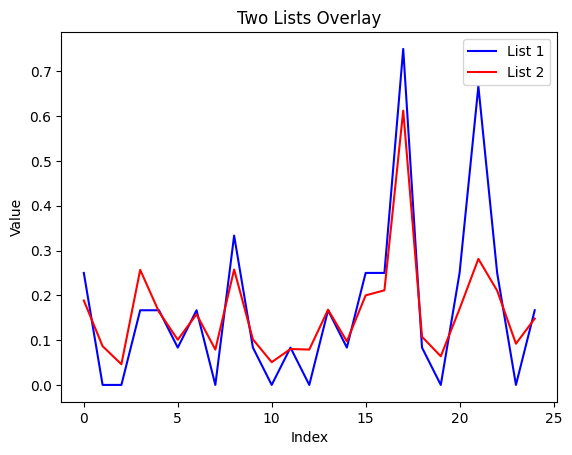

In [444]:
# Plotting
plt.plot(list1, label='List 1', color='blue')
plt.plot(list2, label='List 2', color='red')

# Customization
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Two Lists Overlay')
plt.legend()

# Display the plot
plt.show()